In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# import my modules for reading dataframes from folder /modules

import sys

sys.path.insert(0, 'modules/')
    
from tumor_data_processor import * 
from tumor_data_processor_2 import * 
from lengths_data_processor import *

In [62]:
data = pd.read_csv('datasets/P6.Inform/I062.022.WGS.Tumor_events.txt', sep='\t', comment='#')

data

,Chromosome Region,Event,Length,Cytoband,% of CNV Overlap,Probe Median,% Heterozygous,Probes,Count of Gene Symbols
0,"chr1:862,439-1,313,714",CN Gain,451276,p36.33,100.000000,0.254980,NaN,15,35
1,"chr1:2,323,340-2,500,322",CN Gain,176983,p36.32,98.491937,0.372007,NaN,6,8
2,"chr1:9,840,751-10,297,200",CN Loss,456450,p36.22,4.657695,-0.247301,NaN,14,8
3,"chr1:28,313,363-29,454,028",CN Loss,1140666,p35.3,5.721575,-0.252082,NaN,34,25
4,"chr1:32,265,271-32,656,728",CN Loss,391458,p35.2 - p35.1,6.300564,-0.241056,NaN,12,7
...,...,...,...,...,...,...,...,...,...
374,"chrX:153,411,122-153,945,270",High Copy Gain,534149,q28,100.000000,0.746978,NaN,16,37
375,"chrX:153,945,270-154,722,592",CN Gain,777323,q28,100.000000,0.346073,NaN,24,47
376,"chrX:154,722,592-155,270,560",CN Loss,547969,q28,89.647206,-0.355816,NaN,15,8
377,"chrY:3,095,792-7,022,409",CN Loss,3926618,p11.2,10.072309,-0.745243,NaN,12,19


In [63]:
test_data = process_tumor_data(data)

test_data

,Chromosome,Copy Number,Length,Start,End
0,1,3,451276,862439,1313714
1,1,3,176983,2323340,2500322
2,1,1,456450,9840751,10297200
3,1,1,1140666,28313363,29454028
4,1,1,391458,32265271,32656728
...,...,...,...,...,...
347,22,1,539800,28754409,29294208
348,22,1,423408,31741627,32165034
349,22,3,459942,37448717,37908658
350,22,1,1851736,40438665,42290400


In [4]:
lengths = pd.read_csv('datasets/hs37d5.fa.fai', sep='\t', header=None)

In [5]:
lengths = process_lengths_data(lengths)

# data is in good format
lengths

,Length
Chromosome,
1,249250621
2,243199373
3,198022430
4,191154276
5,180915260
6,171115067
7,159138663
8,146364022
9,141213431


In [6]:
# set copy number values from events to current bin
def update_bin_value(_bin, bin_start, bin_end, event_start, event_end, event_cn):
    
    # if event starts before bin start and ends somewhere after or at bin start
    if event_start <= bin_start and event_end >= bin_start:
        update_start = 0
        
        # if event ends after bin end
        if event_end >= bin_end:
            update_end = bin_end
            
        # if event ends somewhere in bin
        else:
            update_end = event_end - bin_start
            
        _bin[update_start:update_end+1] = event_cn
        
    # if event starts somewhere in bin and ends after bin start
    elif event_start <= bin_end and event_end >= bin_start:
        update_start = event_start - bin_start
        
        # if event ends after bin end
        if event_end >= bin_end:
            update_end = bin_end
            
         # if event ends somewhere inside bin
        else:
            update_end = event_end - bin_start
            
        _bin[update_start:update_end+1] = event_cn
        
    

# split one chromosome to bigger units - bins, default bin size = 30000 bases
def split_chromosome_to_bins(chromosome_data, chromosome_len, bin_len=30000):
    bins = []
    
    # iteration over chromosome length by steps of size bin length
    for base in range(1, chromosome_len+1, bin_len):
        if chromosome_len - base < bin_len:  # last short bin
            curr_bin_len = chromosome_len - base
        else:
            curr_bin_len = bin_len
            
        # initialize bin values
        _bin = np.full((curr_bin_len), 2)
        
        bin_start = base
        bin_end = base + bin_len - 1
        
        # iterate through cnv events
        for index, row in chromosome_data.iterrows():
            event_start = row['Start']
            event_end = row['End']
            event_copy_number = row['Copy Number']
            
            update_bin_value(_bin, bin_start, bin_end, event_start, event_end, event_copy_number)
        
        # counting average of bases cn values in current bin
        bin_avg = np.average(_bin)
        bins.append(bin_avg)
    
    return bins

In [7]:
def plot_bins(bins):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(bins, color='k')
    ax.set_ylim([-0.5, 4.5])
    ax.set_xlim([0, len(bins)])

    ax.axhline(y=2, color='gray', dashes=(5, 5))

In [8]:
def scatter_bins(bins):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(range(len(bins)), bins, c='k', s=8)
   
    ax.set_ylim([-0.5, 4.5])
    ax.set_xlim([0, len(bins)])

    ax.axhline(y=2, color='gray', dashes=(5, 5))

In [9]:
# list holding names of chromosomes (not sex chromosomes)
chromosome_names = [str(_chr) for _chr in range(1, 23)]

chromosome_names

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22']

In [108]:
# split all chromosomes of one genome to bins (not X and Y )
def split_genome_to_bins(data, bin_len=30000):
    
    # bins will be stored in 2-d list (every sublist represents bins of one chromosome)
    bins = []
    
    # iterate through chromosome names except X and Y
    for _chr in chromosome_names:
        
        # filter events of current chromosome
        chr_data = data[data['Chromosome'] == _chr]
        
        # length of current chromosome
        chr_len = lengths.loc[[_chr]]['Length'].item()
        
        # split current chromosome to bins
        chr_bins = split_chromosome_to_bins(chr_data, chr_len, bin_len=bin_len)
        
        # add current chromosome bins to list
        bins.append(chr_bins)
        
    return bins

In [11]:
# flatten 2-d array
def flatten_bins(bins):
    return [value for _chr in bins for value in _chr]

In [12]:
# count areas that bins with deviated CN creates between its records and axis - y = 2
def count_chromosome_area(chromosome_bins):
    area = 0
    for _bin in chromosome_bins:
        area += abs(_bin - 2)
        
    return area

In [13]:
# count absolute areas of all chromosomes of genome
def count_genome_areas(bins):
    
    # areas will be stored in 1-d list (every item represents area of one chromosome)
    areas = []
    for _chr in bins:
        chr_area = count_chromosome_area(_chr)
        areas.append(chr_area)
        
    return areas

In [36]:
def visualize_areas_bar(areas, ylim=None):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(chromosome_names, areas)
    ax.set_ylim(ylim)

In [15]:
# count relative areas of chromosomes against their lengths
def count_relative_areas(areas, bins):
    relative_areas = []
    for idx, area in enumerate(areas):
        
        # length (in bins) of current chromosome
        chr_len = len(bins[idx])
        
        # count relative area
        relative_area = area / chr_len
        relative_areas.append(relative_area)
        
    return relative_areas

In [16]:
# count rate of bases in genome with deviated CN values
def count_cnv_rate(data):
    
    # count length of all chromosomes in genome
    genome_length = lengths['Length'].sum(axis=0)
    
    # count sum of events lengths
    cnv_events_length = data['Length'].sum(axis=0)
    
    # return CNV rate of genome
    return cnv_events_length / genome_length

In [17]:
from collections import Counter

In [18]:
def intersection(s1, s2) : 
  
    # Find the intersection of the two sets  
    intersect = list((Counter(s1) & Counter(s2)).elements())

    return intersect


def jaccard(bins1, bins2):
    # Sizes of both the sets  
    size1 = len(bins1)
    size2 = len(bins2)  
  
    # Get the intersection set  
    intersect = intersection(bins1, bins2)
  
    # Size of the intersection set  
    size_in = len(intersect)
  
    # Calculate the Jaccard index  
    # using the formula  
    jaccard_in = size_in  / (size1 + size2 - size_in)  
  
    # Return the Jaccard index  
    return jaccard_in

In [19]:
import os

In [20]:
def read_files_test(directory_path):
    for filename in  os.listdir(directory_path):
        if filename.endswith(".txt"):
            relative_path = os.path.join(directory_path, filename)
            print(relative_path)

In [21]:
read_files_test('datasets/P6.Inform')

datasets/P6.Inform\I062.007.WGS.Pre_events.txt
datasets/P6.Inform\I062.007.WGS.Tumor_events.txt
datasets/P6.Inform\I062.015.WGS.Tumor_events.txt
datasets/P6.Inform\I062.022.WGS.Tumor_events.txt
datasets/P6.Inform\I062.033.WGS.Tumor_events.txt


In [22]:
# read data of all tumors
def read_tumors(directory_path):
    tumors = []
    for filename in os.listdir(directory_path)[:-1]:
         if filename.endswith(".txt"):
            relative_path = os.path.join(directory_path, filename)
            data = pd.read_csv(relative_path, sep='\t', comment='#')
            data = process_tumor_data(data)
            
            tumors.append(data)
    
    filename = os.listdir(directory_path)[-1]
    relative_path = os.path.join(directory_path, filename)
    data = pd.read_csv(relative_path, sep='\t', header=None)
    data = process_tumor_data_2(data)
    tumors.append(data)
    
    return tumors

In [23]:
tumors = read_tumors('datasets\P6.Inform')

tumors

[    Chromosome  Copy Number   Length     Start       End
 0            1            1   745088   2789792   3534879
 1            1            3  1235765   9453839  10689603
 2            1            3  1305427  15793573  17098999
 3            1            3  1505877  28045550  29551426
 4            1            3   793193  32425081  33218273
 ..         ...          ...      ...       ...       ...
 98          21            3   361580  10265852  10627431
 100         22            1   235248  18636876  18872123
 101         22            3   369487  21665277  22034763
 102         22            3   426659  31774440  32201098
 103         22            1  1147816  48918773  50066588
 
 [98 rows x 5 columns],
     Chromosome  Copy Number    Length      Start        End
 1            1            3   2482505   85008845   87491349
 2            1            3   7563961  113613048  121177008
 4            1            3   1866103  144014595  145880697
 5            1            3   268

In [111]:
# split all tumors to bins
def split_tumors_to_bins(tumors, bin_len=30000):
    tumors_bins = []
    for tumor in tumors:
        tumor_bins = split_genome_to_bins(tumor, bin_len=bin_len)
        tumors_bins.append(tumor_bins)
    
    return tumors_bins

In [112]:
tumors_bins = split_tumors_to_bins(tumors, bin_len=100000)

In [26]:
# flatten all tumors bins
def flatten_tumors_bins(tumors_bins):
    flattened_tumors_bins = []
    for tumor_bins in tumors_bins:
        flattened_bins = flatten_bins(tumor_bins)
        flattened_tumors_bins.append(flattened_bins)
        
    return flattened_tumors_bins

In [27]:
flattened_tumors_bins = flatten_tumors_bins(tumors_bins)

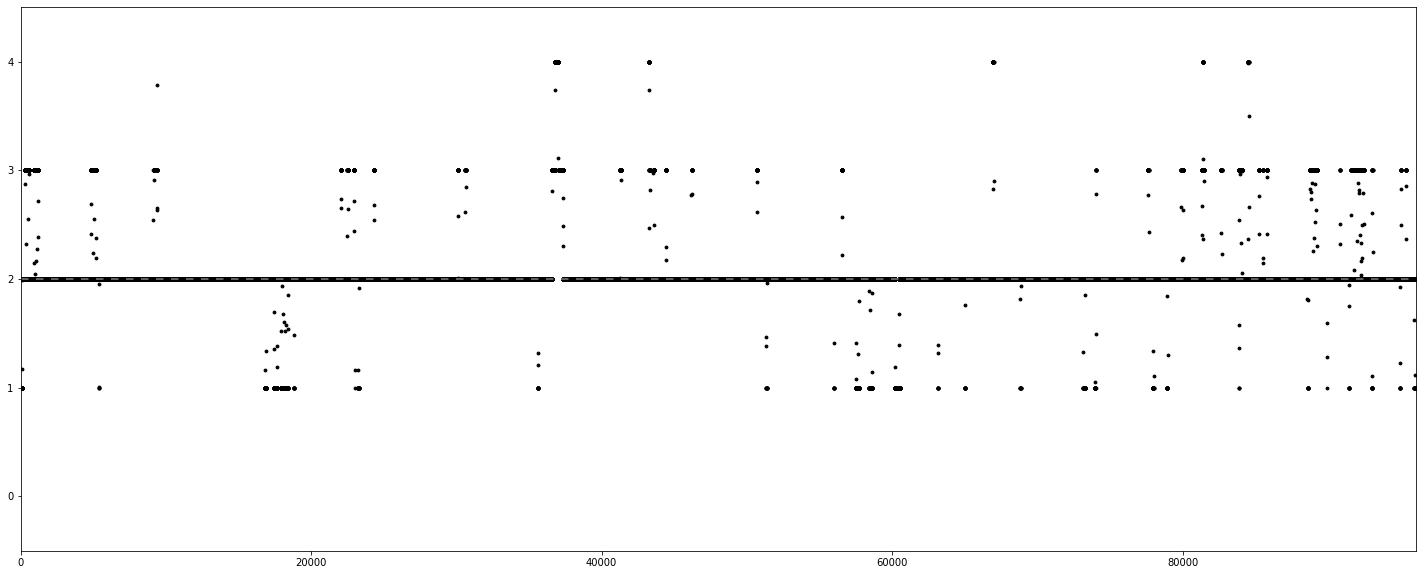

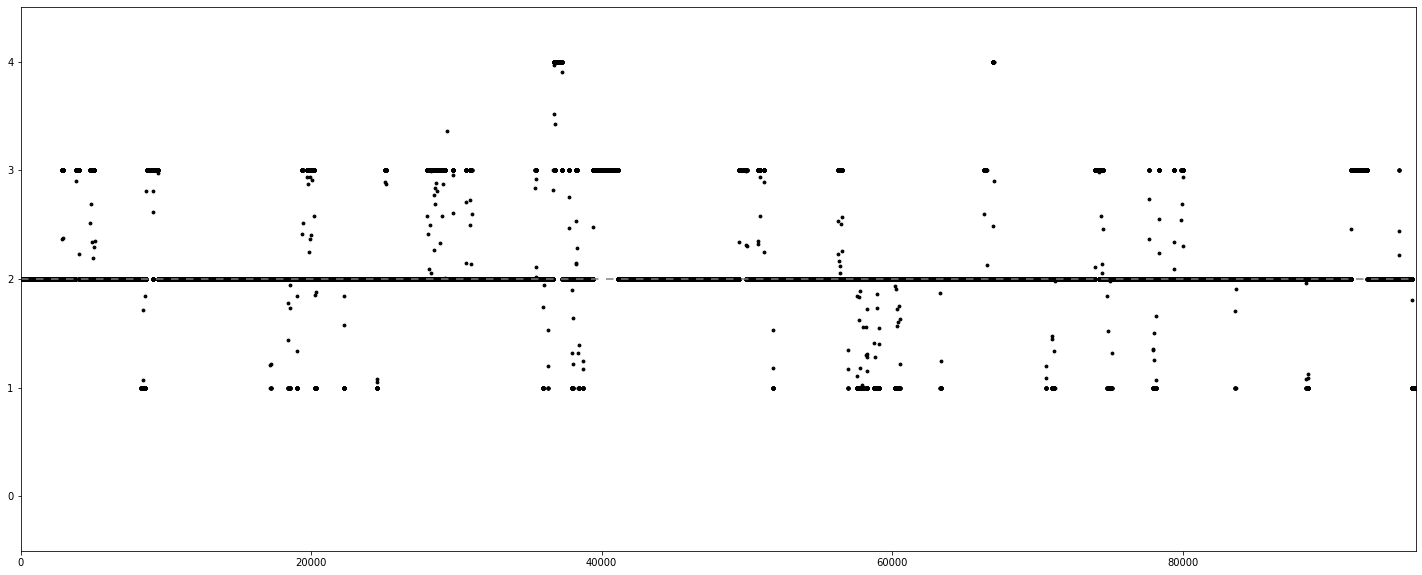

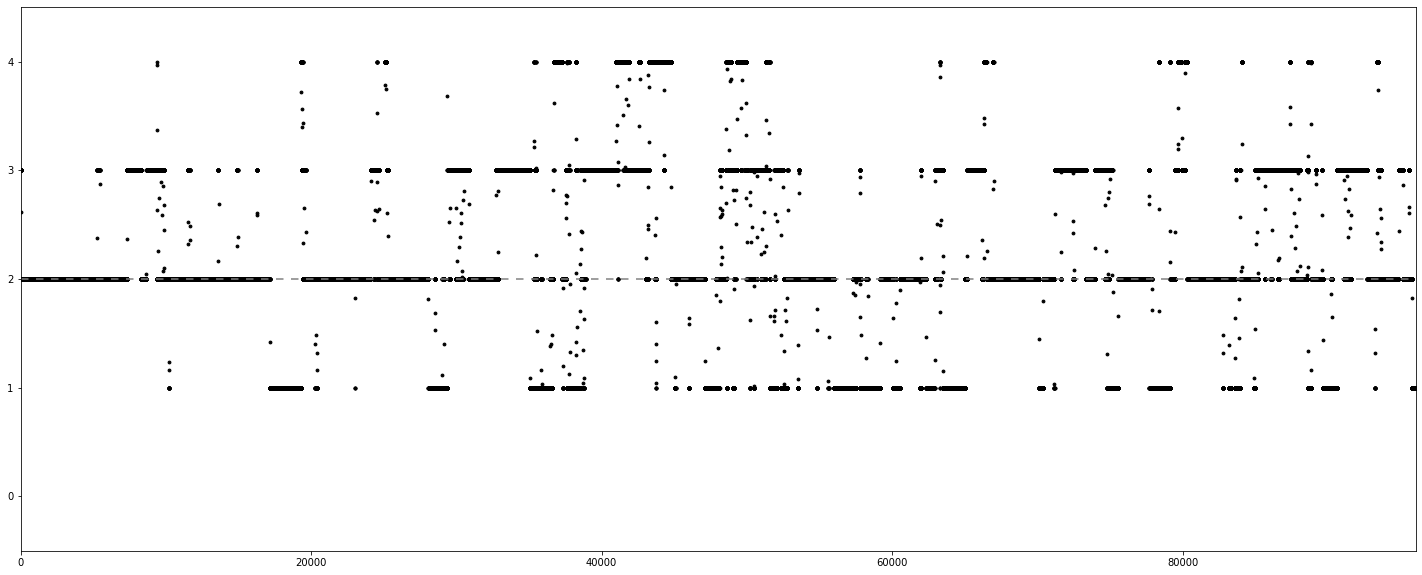

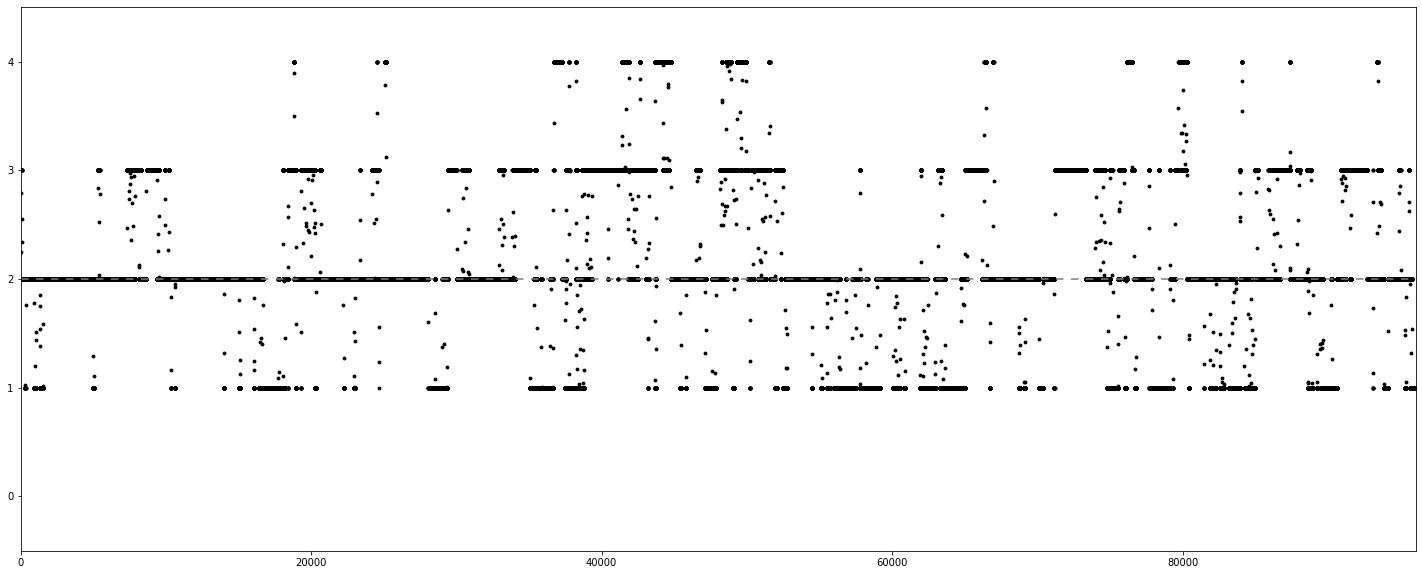

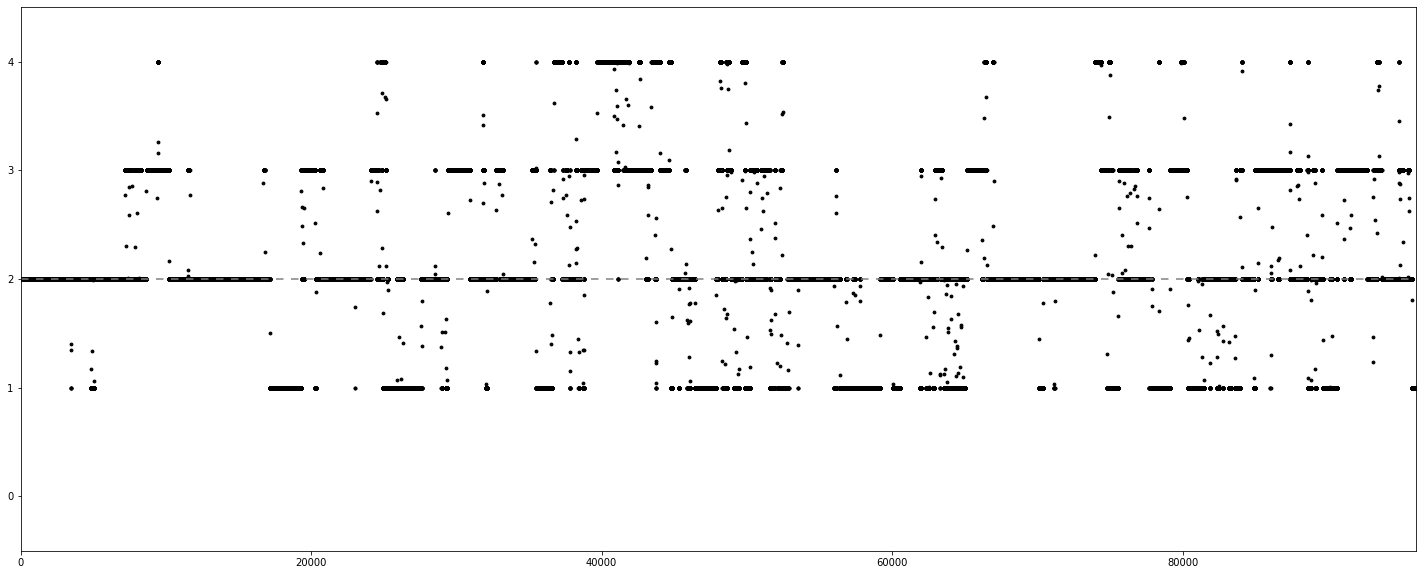

In [128]:
# scatter plot for every tumors genome
for flattened_bins in flattened_tumors_bins:
    scatter_bins(flattened_bins)

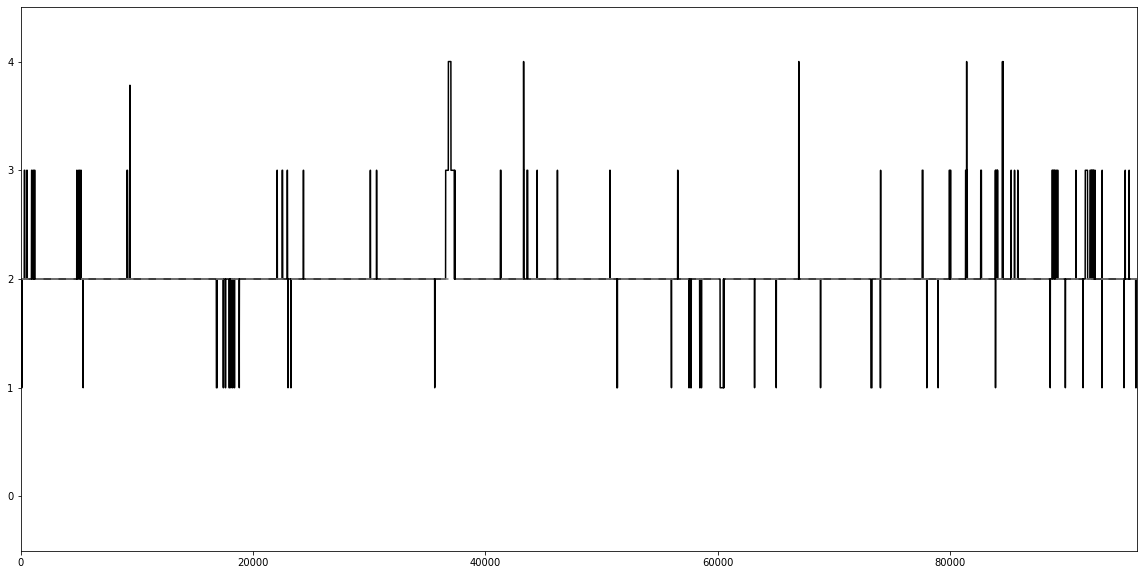

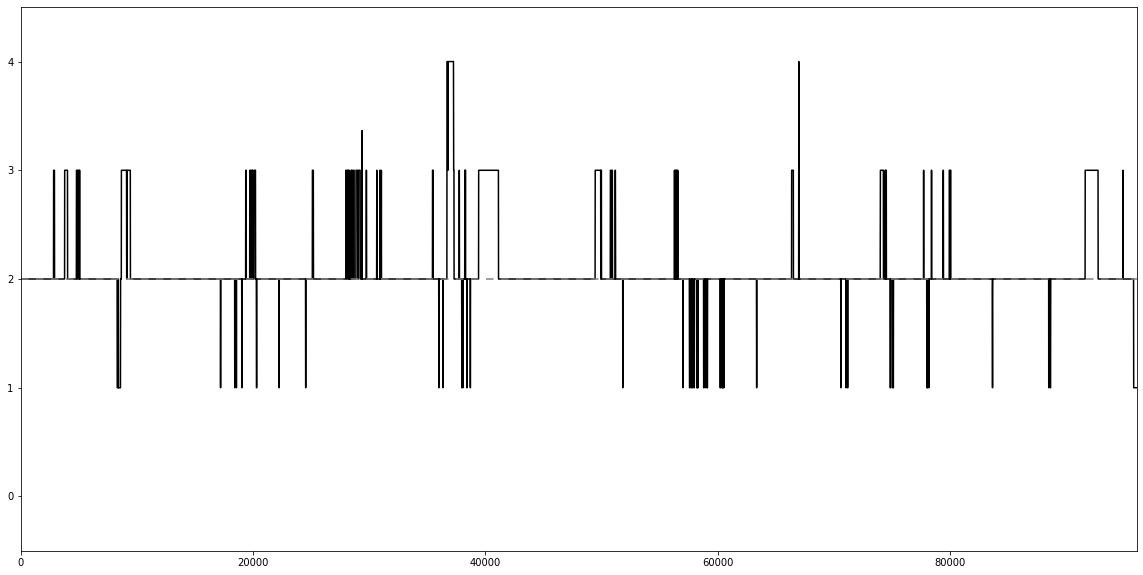

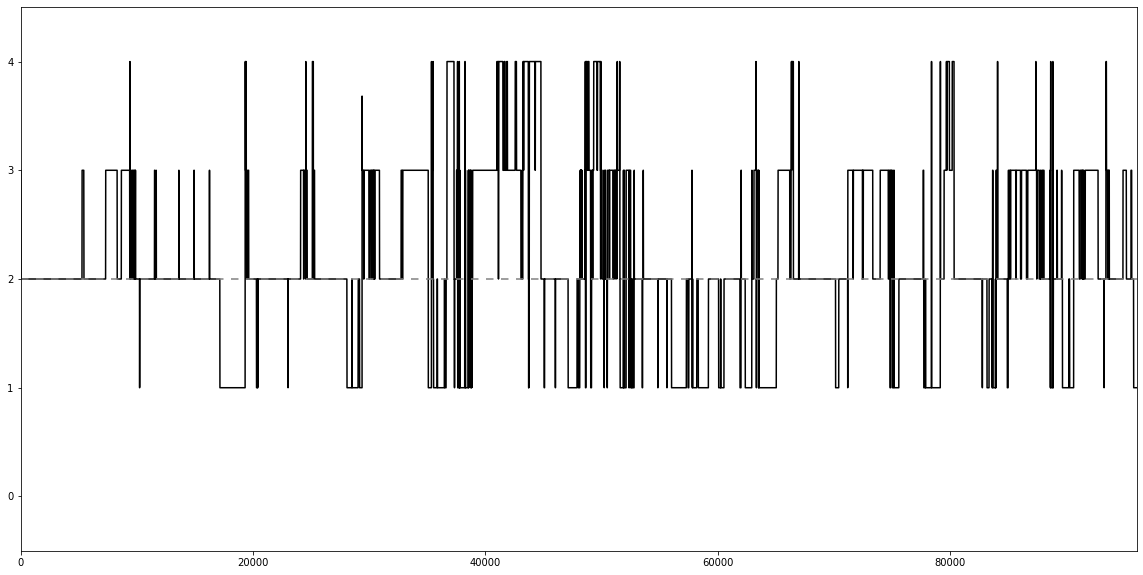

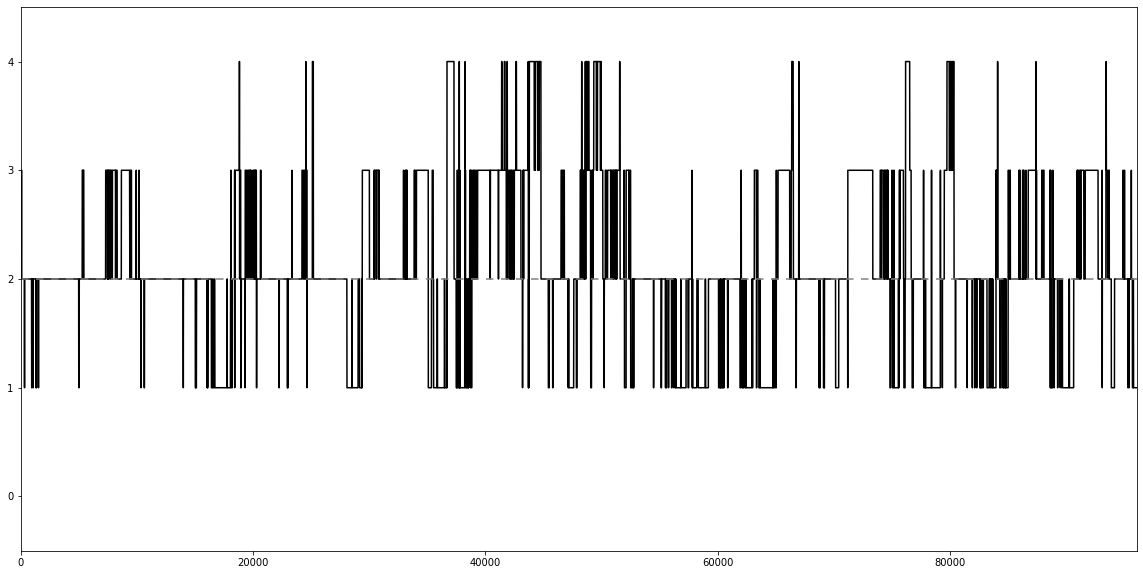

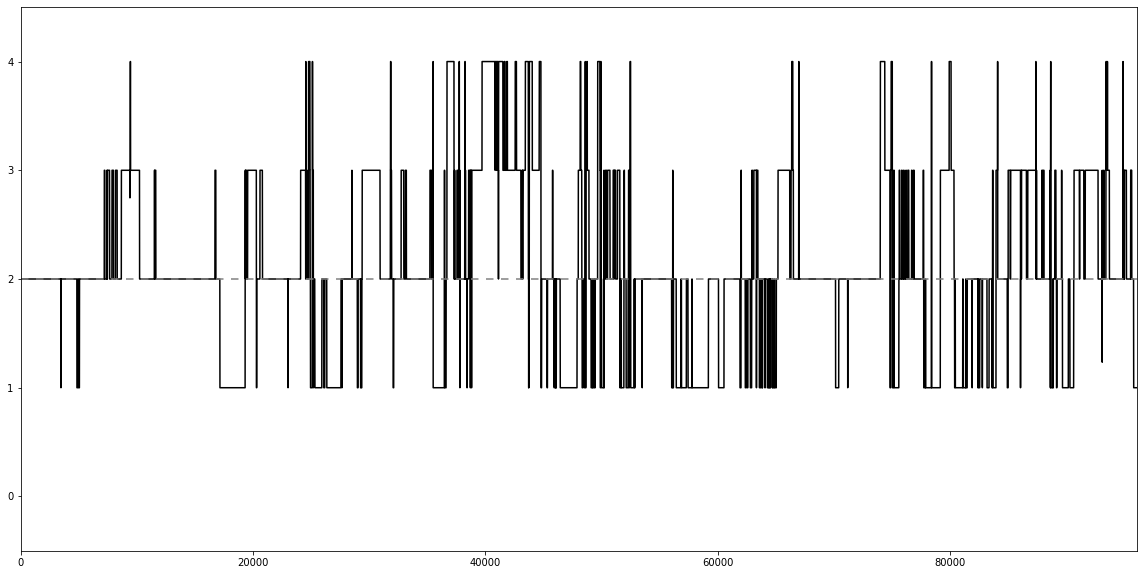

In [127]:
# plot bins of every tumors genome
for flattened_bins in flattened_tumors_bins:
    plot_bins(flattened_bins)

In [30]:
# count areas of every chromosome of every tumors genome
def count_tumors_areas(tumors_bins):
    tumors_areas = []
    for tumor_bins in tumors_bins:
        tumor_areas = count_genome_areas(tumor_bins)
        tumors_areas.append(tumor_areas)
        
    return tumors_areas

In [126]:
tumors_areas = count_tumors_areas(tumors_bins)

tumors_areas

[[117.83530000000002,
  19.95697,
  94.42714,
  14.39569,
  11.11612,
  300.49969999999996,
  63.73314000000001,
  7.35166,
  6.23451,
  139.89408,
  6.25865,
  17.39299,
  28.14679,
  9.16835,
  56.78137,
  48.632560000000005,
  72.21856000000001,
  3.1136,
  82.60574,
  133.67007999999998,
  6.5585,
  21.792060000000003],
 [155.47513,
  306.77379,
  124.05647,
  214.29769000000002,
  24.827559999999995,
  912.7041099999999,
  0.0,
  193.88200000000003,
  4.88547,
  175.78206,
  5.66547,
  60.63546,
  15.140479999999998,
  148.69862,
  56.578570000000006,
  0.0,
  2.2149900000000002,
  11.92132,
  0.0,
  334.73887,
  0.0,
  80.45617],
 [350.77067,
  320.01101,
  760.5239499999998,
  591.67814,
  1149.26074,
  1768.3238499999998,
  1662.8457400000002,
  1196.96456,
  450.3674800000001,
  916.7564199999999,
  776.3964000000001,
  427.69501999999994,
  711.1087,
  455.88316,
  828.5094700000001,
  59.43946,
  419.32651,
  488.82254,
  353.04525,
  545.94253,
  74.41567,
  182.72548999999

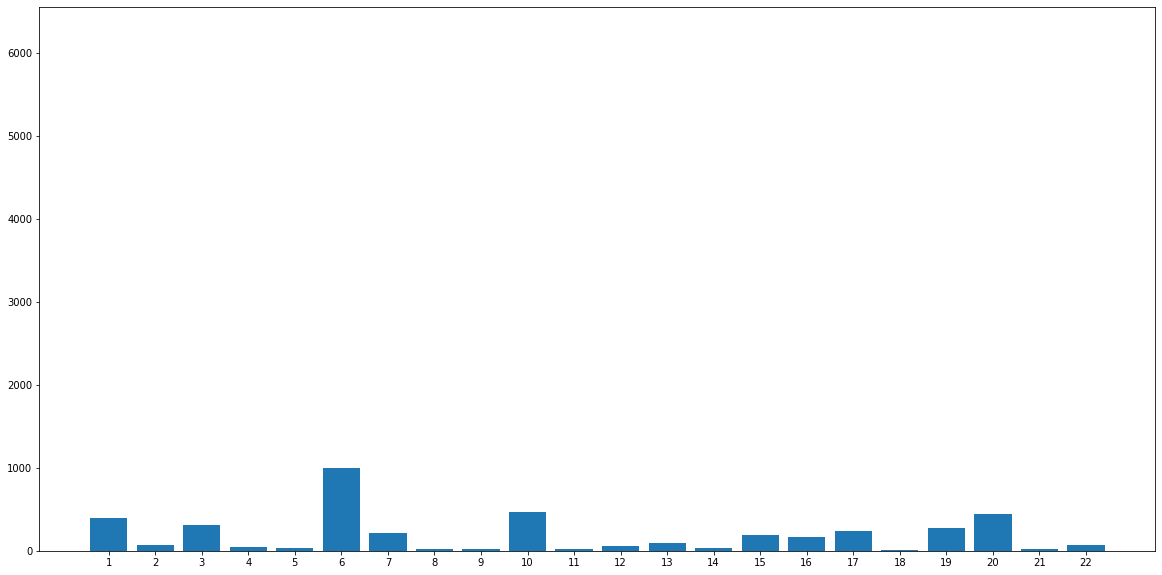

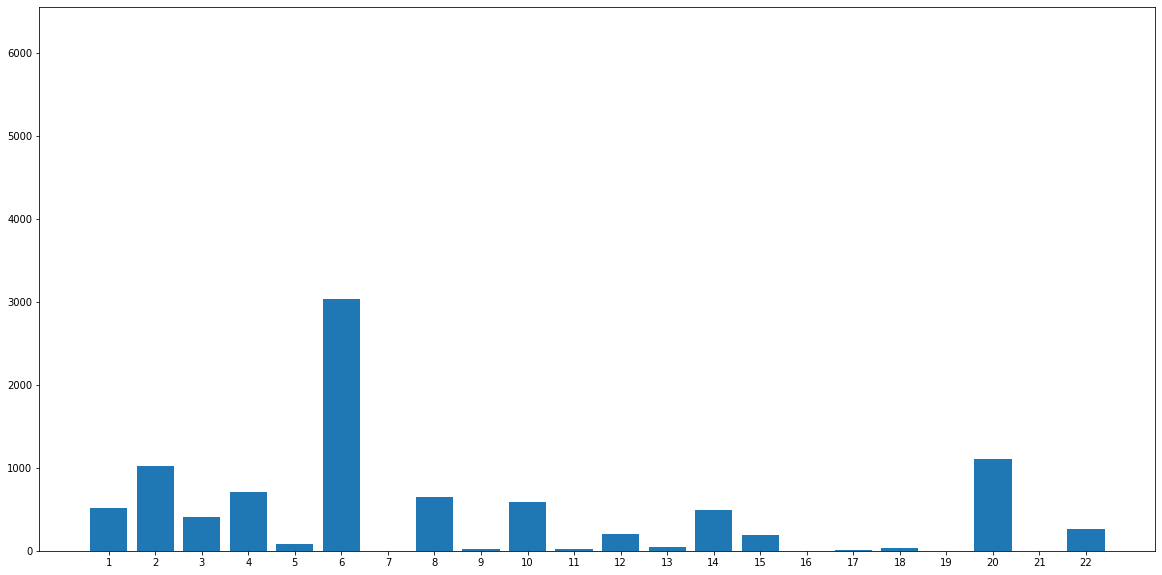

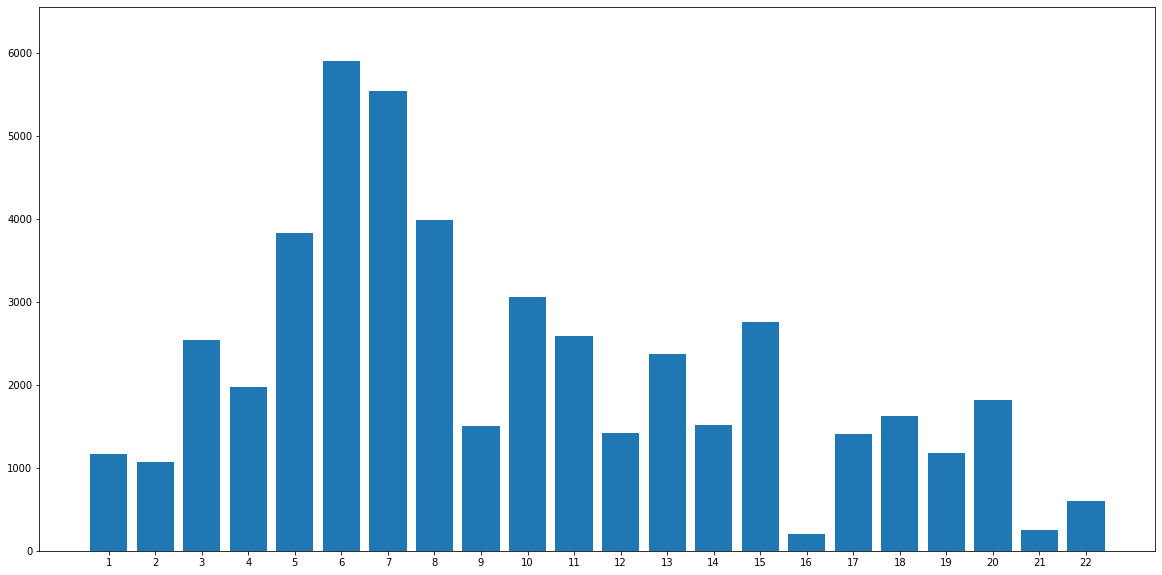

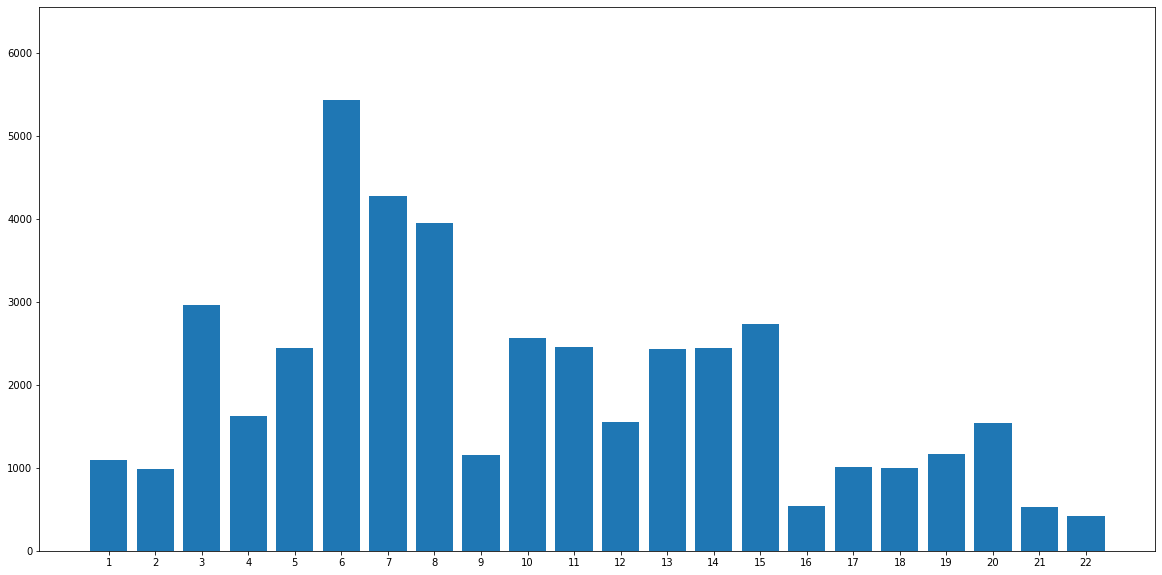

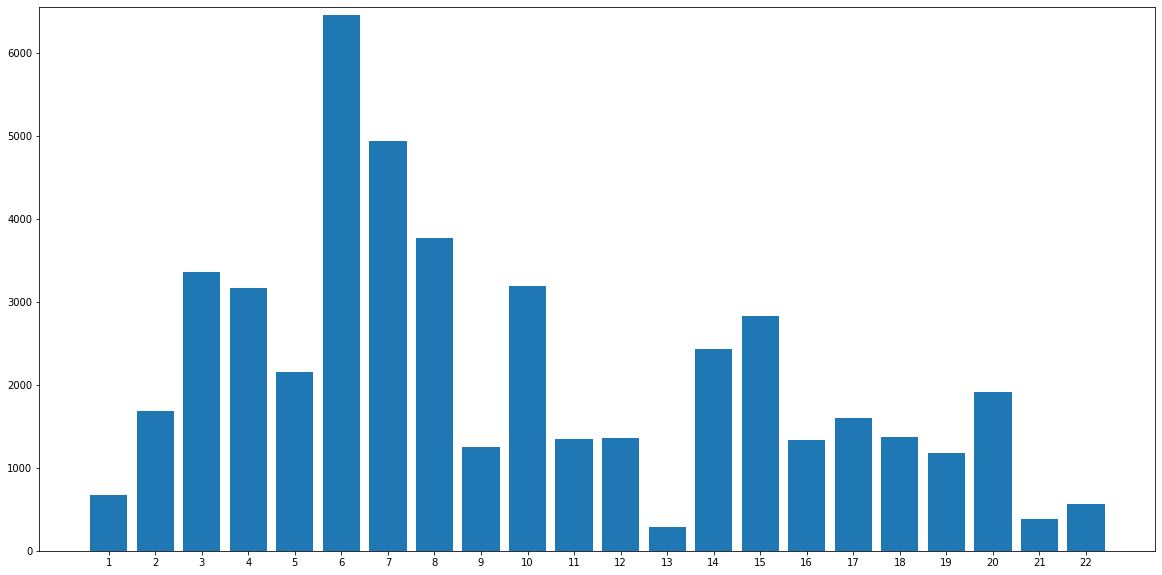

In [125]:
# visualizing areas of every single chromosome of every single tumor
for tumor_areas in tumors_areas:
    visualize_areas_bar(tumor_areas, ylim=[0, np.max(tumors_areas)+100])

In [38]:
# counting relative areas of every chromosome of every tumor
def count_tumors_relative_areas(tumors_areas, tumors_bins):
    tumors_relative_areas = []
    for idx, tumor_areas in enumerate(tumors_areas):
        tumor_relative_areas = count_relative_areas(tumor_areas, tumors_bins[idx])
        tumors_relative_areas.append(tumor_relative_areas)
        
    return tumors_relative_areas

In [119]:
tumors_relative_areas = count_tumors_relative_areas(tumors_areas, tumors_bins)
    
tumors_relative_areas

[[0.1575548870169809,
  0.027353303179824564,
  0.15888800269224299,
  0.0250971059972106,
  0.020471675874769796,
  0.585085085669782,
  0.13344459798994976,
  0.016738752276867032,
  0.013292073602264686,
  0.34241415929203534,
  0.013714902541327411,
  0.04329845655962161,
  0.08144325810185185,
  0.029076194909993792,
  0.1844748862897986,
  0.17932359882005902,
  0.29967766830870274,
  0.013288945795988051,
  0.46512240990991,
  0.7061282620179612,
  0.049269571230982016,
  0.14132334630350196],
 [0.2078822436154566,
  0.4204684621710526,
  0.20874384990745415,
  0.3736012726638772,
  0.04572294659300185,
  1.7755142328660436,
  0.0,
  0.44144353369763206,
  0.011525053078556264,
  0.4321092920353982,
  0.013978460399703923,
  0.15094712471994026,
  0.04380925925925926,
  0.46151030415890754,
  0.1838160168940871,
  0.0,
  0.009092733990147784,
  0.050880580452411436,
  0.0,
  1.7646004754358162,
  0.0,
  0.5172254863813229],
 [0.46860632437491645,
  0.43861158168859676,
  1.28104

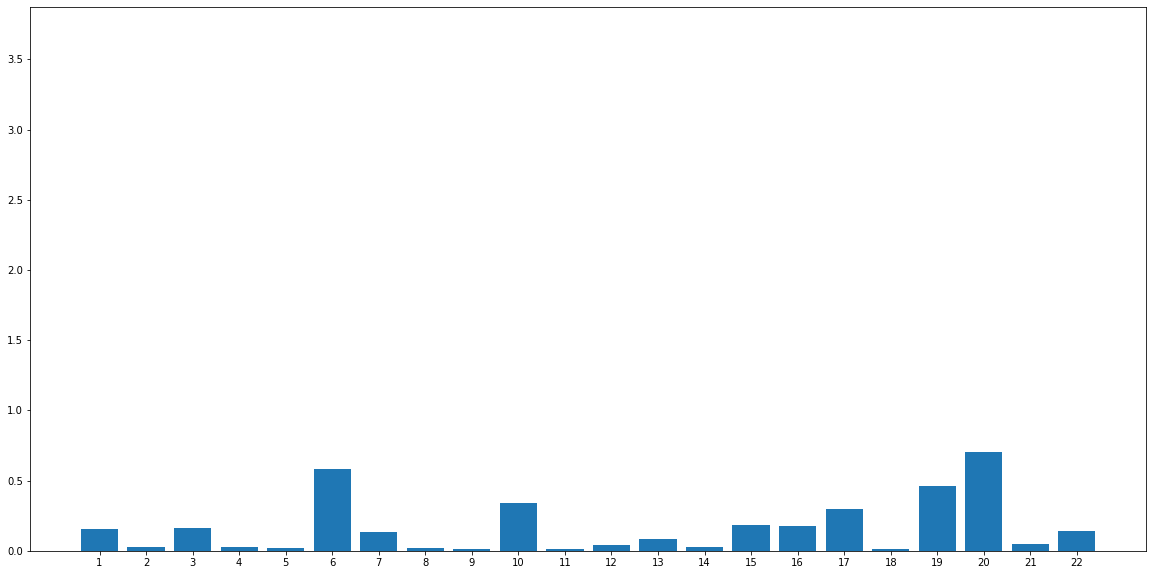

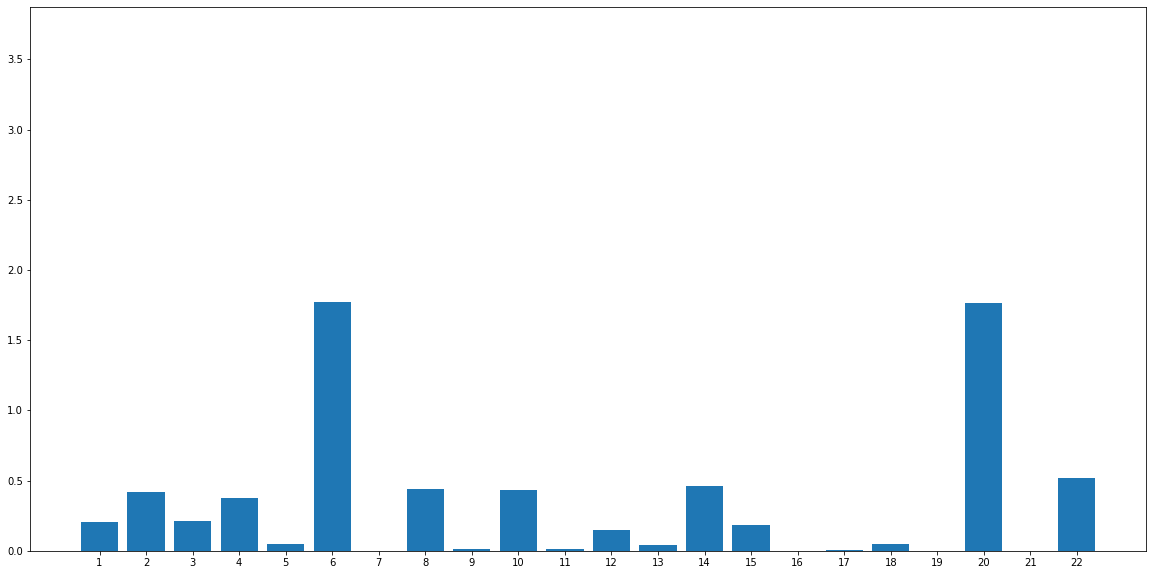

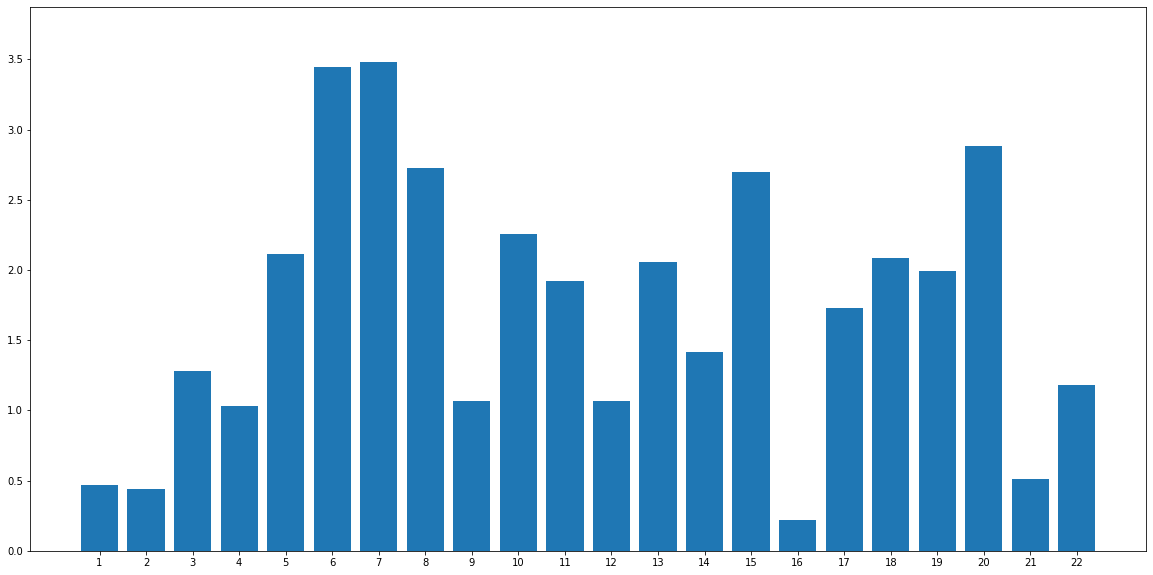

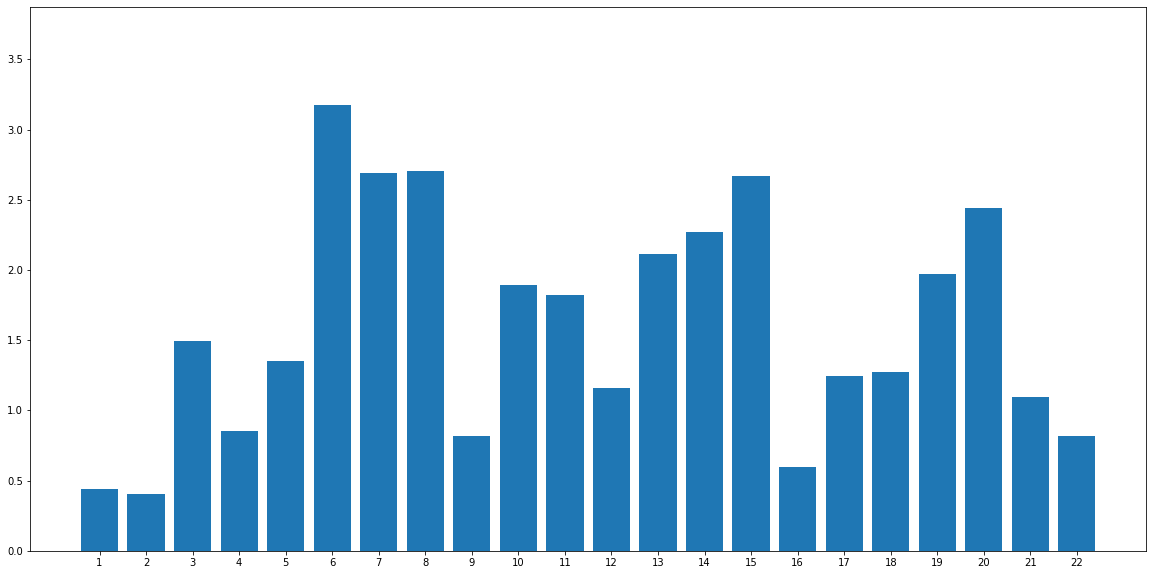

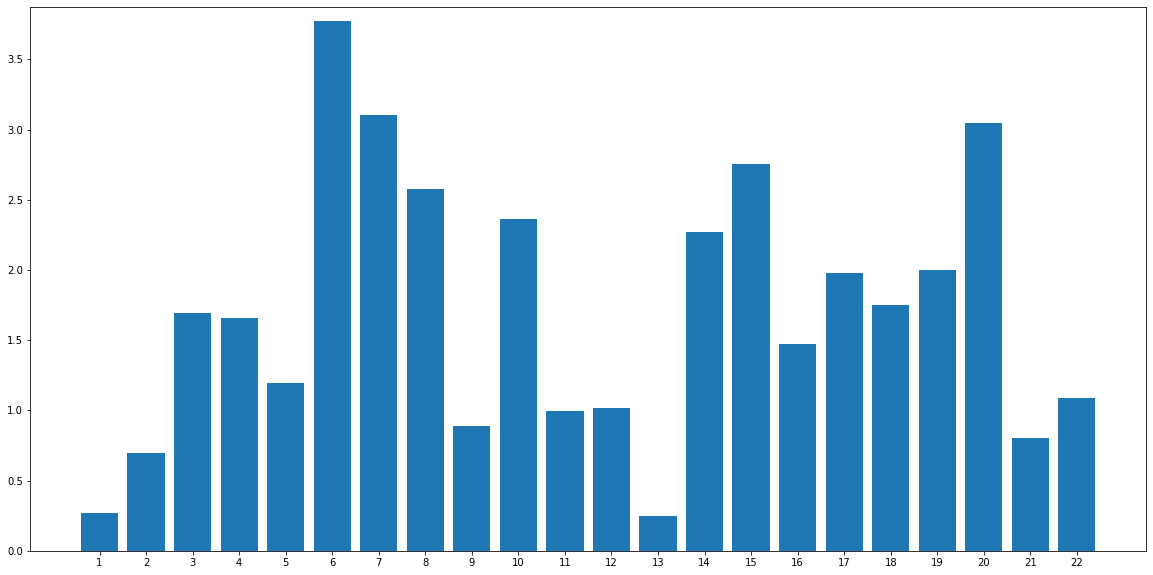

In [122]:
for tumor_relative_areas in tumors_relative_areas:
    visualize_areas_bar(tumor_relative_areas, [0, np.max(tumors_relative_areas) + 0.1])

In [41]:
# count ratio of cnv on all tumors
def count_tumors_cnv_rates(tumors):
    cnv_rates = []
    for tumor in tumors:
        cnv_rate = count_cnv_rate(tumor)
        cnv_rates.append(cnv_rate)
        
    return cnv_rates

In [117]:
cnv_rates = count_tumors_cnv_rates(tumors)

cnv_rates

[0.03786298163550382,
 0.08589494530963099,
 0.4250115967832633,
 0.395492801108438,
 0.41283430794371156]

In [43]:
# visualize and compare cnv of every tumor
def visualize_cnv_rates(cnv_rates):
    tumors_names = ['P', 'Rec4', 'Rec5', 'Rec6', 'Rec7']
    fig, ax = plt.subplots(figsize=(8,8))
    ax.bar(tumors_names, cnv_rates)
    ax.set_ylim([0, 1])

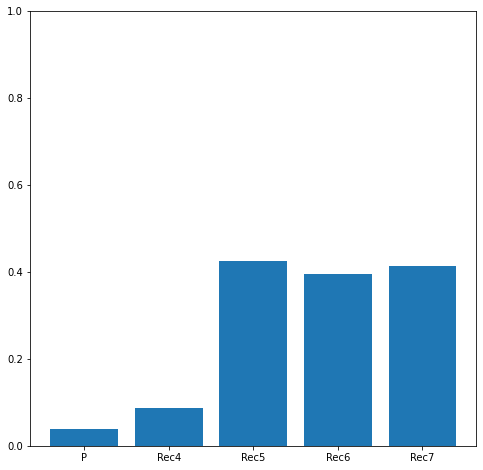

In [113]:
visualize_cnv_rates(cnv_rates)

In [94]:
def count_jaccard_matrix(tumors_bins):
    jaccard_matrix = {}
    tumors_names = ['P', 'Rec4', 'Rec5', 'Rec6', 'Rec7']

    for i in range(len(tumors_names)):
        for j in range(i+1, len(tumors_names)):
            bins1 = tumors_bins[i]
            bins2 = tumors_bins[j]

            tumor1_name = tumors_names[i]
            tumor2_name = tumors_names[j]
            
            jaccard_matrix[(tumor2_name, tumor1_name)] = jaccard(bins1, bins2)
            
    return jaccard_matrix

In [114]:
jaccard_matrix = count_jaccard_matrix(flattened_tumors_bins)

jaccard_matrix

{('Rec4', 'P'): 0.8982705800968475,
 ('Rec5', 'P'): 0.4101159888415798,
 ('Rec6', 'P'): 0.4412214885954382,
 ('Rec7', 'P'): 0.4229435818418869,
 ('Rec5', 'Rec4'): 0.4633451415076372,
 ('Rec6', 'Rec4'): 0.4969995479838521,
 ('Rec7', 'Rec4'): 0.47726643492170917,
 ('Rec6', 'Rec5'): 0.9283613255564145,
 ('Rec7', 'Rec5'): 0.9365655465827863,
 ('Rec7', 'Rec6'): 0.9439148298824054}

In [115]:
def jaccard_matrix_to_df(jaccard_matrix):
    jaccard_matrix = count_jaccard_matrix(flattened_tumors_bins)
    jaccard_series = pd.Series(list(jaccard_matrix.values()),
                      index=pd.MultiIndex.from_tuples(jaccard_matrix.keys()))
    jaccard_df = jaccard_series.unstack()
    
    return jaccard_df

In [124]:
jaccard_df = jaccard_matrix_to_df(jaccard_matrix)

jaccard_df

,P,Rec4,Rec5,Rec6
Rec4,0.898271,NaN,NaN,NaN
Rec5,0.410116,0.463345,NaN,NaN
Rec6,0.441221,0.497000,0.928361,NaN
Rec7,0.422944,0.477266,0.936566,0.943915


<AxesSubplot:>

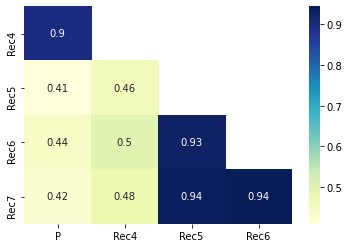

In [123]:
sns.heatmap(jaccard_df, cmap="YlGnBu", annot=True, mask=jaccard_df.isnull())